In [1]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

dataset_dir = "/kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/RetinalOCT_Dataset"

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset = datasets.ImageFolder(os.path.join(dataset_dir, 'train'), transform=train_transforms)
val_dataset = datasets.ImageFolder(os.path.join(dataset_dir, 'val'), transform=val_test_transforms)
test_dataset = datasets.ImageFolder(os.path.join(dataset_dir, 'test'), transform=val_test_transforms)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

def print_dataset_info(name, dataset):
    print(f"{name} dataset:")
    print(f"Number of images: {len(dataset)}")
    print(f"Number of classes: {len(dataset.classes)}")
    print(f"Classes: {dataset.classes}\n")

print_dataset_info("Train", train_dataset)
print_dataset_info("Validation", val_dataset)
print_dataset_info("Test", test_dataset)

for images, labels in train_loader:
    print(f"Shape of images batch: {images.shape}")
    print(f"Shape of labels batch: {labels.shape}")
    break

Train dataset:
Number of images: 18400
Number of classes: 8
Classes: ['AMD', 'CNV', 'CSR', 'DME', 'DR', 'DRUSEN', 'MH', 'NORMAL']

Validation dataset:
Number of images: 2800
Number of classes: 8
Classes: ['AMD', 'CNV', 'CSR', 'DME', 'DR', 'DRUSEN', 'MH', 'NORMAL']

Test dataset:
Number of images: 2800
Number of classes: 8
Classes: ['AMD', 'CNV', 'CSR', 'DME', 'DR', 'DRUSEN', 'MH', 'NORMAL']

Shape of images batch: torch.Size([32, 3, 224, 224])
Shape of labels batch: torch.Size([32])


In [2]:
import torch
import torch.nn as nn

class AtrousConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dilation):
        super(AtrousConvBlock, self).__init__()
        self.conv = nn.Conv2d(
            in_channels, out_channels, kernel_size=3, padding=dilation, dilation=dilation
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class AtrousClassifier(nn.Module):
    def __init__(self, in_channels, num_classes, input_size=224):
        super(AtrousClassifier, self).__init__()

        self.atrous1 = AtrousConvBlock(in_channels, 64, dilation=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.atrous2 = AtrousConvBlock(64, 128, dilation=2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.atrous3 = AtrousConvBlock(128, 256, dilation=4)
        self.pool3 = nn.MaxPool2d(2, 2)

        test_input = torch.randn(1, in_channels, input_size, input_size)
        with torch.no_grad():
            x = self.pool1(self.atrous1(test_input))
            x = self.pool2(self.atrous2(x))
            x = self.pool3(self.atrous3(x))
            flattened_size = x.numel()

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(flattened_size, 1024)
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(1024, 512)
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool1(self.atrous1(x))
        x = self.pool2(self.atrous2(x))
        x = self.pool3(self.atrous3(x))

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

num_classes = 8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AtrousClassifier(in_channels=3, num_classes=num_classes, input_size=224).to(device)

dummy_input = torch.randn(1, 3, 224, 224).to(device)
output = model(dummy_input)
print(f"Output shape: {output.shape}")


Output shape: torch.Size([1, 8])



Epoch [1/32]


Epoch [1/32] Summary | Train Loss: 22.3775, Train Acc: 42.23% | Val Loss: 1.6905, Val Acc: 51.00%

Epoch [2/32]


Epoch [2/32] Summary | Train Loss: 1.5113, Train Acc: 52.15% | Val Loss: 0.9575, Val Acc: 59.89%

Epoch [3/32]


Epoch [3/32] Summary | Train Loss: 1.0486, Train Acc: 59.22% | Val Loss: 0.9903, Val Acc: 61.57%

Epoch [4/32]


Epoch [4/32] Summary | Train Loss: 0.7957, Train Acc: 67.56% | Val Loss: 0.5921, Val Acc: 76.18%

Epoch [5/32]


Epoch [5/32] Summary | Train Loss: 0.7320, Train Acc: 71.49% | Val Loss: 0.5611, Val Acc: 78.00%

Epoch [6/32]


Epoch [6/32] Summary | Train Loss: 0.6576, Train Acc: 75.53% | Val Loss: 0.7195, Val Acc: 72.64%

Epoch [7/32]


Epoch [7/32] Summary | Train Loss: 0.5423, Train Acc: 80.12% | Val Loss: 0.4774, Val Acc: 80.82%

Epoch [8/32]


Epoch [8/32] Summary | Train Loss: 0.4485, Train Acc: 83.22% | Val Loss: 0.3735, Val Acc: 87.50%

Epoch [9/32]


Epoch [9/32] Summary | Train Loss: 0.3947, Train Acc: 85.58% | Val Loss: 0.3296, Val Acc: 88.46%

Epoch [10/32]


Epoch [10/32] Summary | Train Loss: 0.4554, Train Acc: 83.96% | Val Loss: 0.3574, Val Acc: 87.18%

Epoch [11/32]


Epoch [11/32] Summary | Train Loss: 0.3599, Train Acc: 86.98% | Val Loss: 0.2898, Val Acc: 89.54%

Epoch [12/32]


Epoch [12/32] Summary | Train Loss: 0.3140, Train Acc: 88.82% | Val Loss: 0.3241, Val Acc: 88.14%

Epoch [13/32]


Epoch [13/32] Summary | Train Loss: 0.3720, Train Acc: 87.25% | Val Loss: 0.3911, Val Acc: 86.71%

Epoch [14/32]


Epoch [14/32] Summary | Train Loss: 0.2934, Train Acc: 89.61% | Val Loss: 0.2628, Val Acc: 91.25%

Epoch [15/32]


Epoch [15/32] Summary | Train Loss: 0.2749, Train Acc: 90.44% | Val Loss: 0.2928, Val Acc: 89.29%

Epoch [16/32]


Epoch [16/32] Summary | Train Loss: 0.2726, Train Acc: 90.67% | Val Loss: 0.2832, Val Acc: 90.79%

Epoch [17/32]


Epoch [17/32] Summary | Train Loss: 0.2738, Train Acc: 90.78% | Val Loss: 0.3030, Val Acc: 89.36%

Epoch [18/32]


Epoch [18/32] Summary | Train Loss: 0.2700, Train Acc: 91.05% | Val Loss: 0.2453, Val Acc: 91.54%

Epoch [19/32]


Epoch [19/32] Summary | Train Loss: 0.2581, Train Acc: 91.24% | Val Loss: 0.3011, Val Acc: 89.68%

Epoch [20/32]


Epoch [20/32] Summary | Train Loss: 0.2670, Train Acc: 90.88% | Val Loss: 0.3508, Val Acc: 89.93%

Epoch [21/32]


Epoch [21/32] Summary | Train Loss: 0.7341, Train Acc: 78.16% | Val Loss: 0.3755, Val Acc: 86.68%

Epoch [22/32]


Epoch [22/32] Summary | Train Loss: 0.5478, Train Acc: 82.02% | Val Loss: 0.4081, Val Acc: 87.36%

Epoch [23/32]


Epoch [23/32] Summary | Train Loss: 0.3450, Train Acc: 88.08% | Val Loss: 0.3163, Val Acc: 88.68%

Epoch [24/32]


Epoch [24/32] Summary | Train Loss: 0.2813, Train Acc: 90.35% | Val Loss: 0.2501, Val Acc: 91.11%

Epoch [25/32]


Epoch [25/32] Summary | Train Loss: 0.2731, Train Acc: 90.82% | Val Loss: 0.2268, Val Acc: 92.07%

Epoch [26/32]


Epoch [26/32] Summary | Train Loss: 0.2473, Train Acc: 91.82% | Val Loss: 0.3023, Val Acc: 90.00%

Epoch [27/32]


Epoch [27/32] Summary | Train Loss: 0.2438, Train Acc: 92.01% | Val Loss: 0.2116, Val Acc: 92.71%

Epoch [28/32]


Epoch [28/32] Summary | Train Loss: 0.6263, Train Acc: 80.84% | Val Loss: 0.3208, Val Acc: 89.50%

Epoch [29/32]


Epoch [29/32] Summary | Train Loss: 0.3174, Train Acc: 89.68% | Val Loss: 0.2364, Val Acc: 92.57%

Epoch [30/32]


Epoch [30/32] Summary | Train Loss: 0.2554, Train Acc: 91.66% | Val Loss: 0.1937, Val Acc: 93.43%

Epoch [31/32]


Epoch [31/32] Summary | Train Loss: 0.2323, Train Acc: 92.54% | Val Loss: 0.2157, Val Acc: 93.39%

Epoch [32/32]


Epoch [32/32] Summary | Train Loss: 0.2303, Train Acc: 92.58% | Val Loss: 0.2727, Val Acc: 90.61%
Best model saved as 'best_model.pth'.


Testing: 100%|██████████| 88/88 [00:35<00:00,  2.49it/s, Loss=0.19]


Test Loss: 0.2822, Test Accuracy: 90.50%


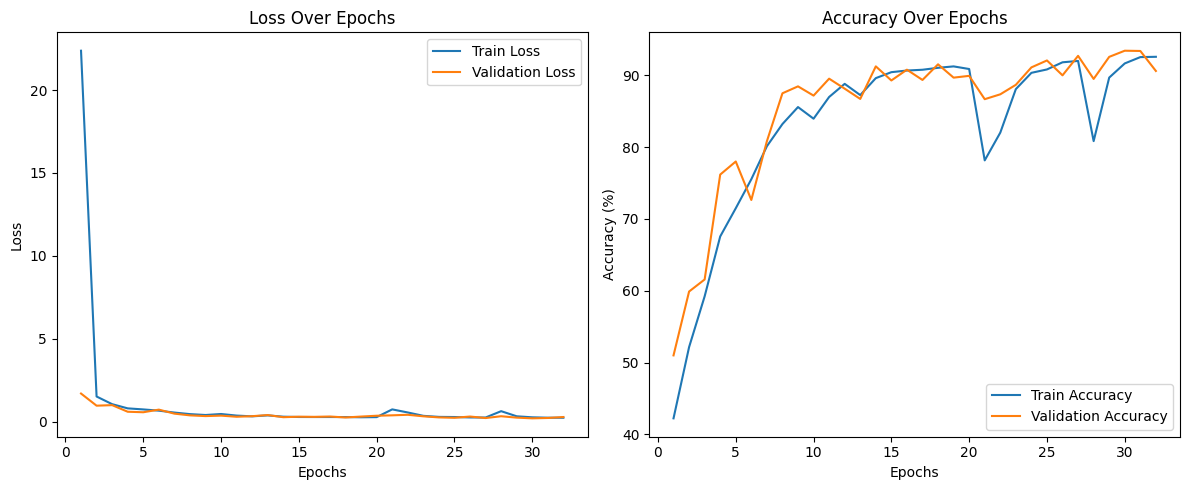

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, test_loader, device, epochs=20, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses, test_losses = [], [], []
    train_accuracies, val_accuracies, test_accuracies = [], [], []

    best_val_loss = float("inf")
    best_model_state = None

    for epoch in range(epochs):
        print(f"\nEpoch [{epoch + 1}/{epochs}]")
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        train_progress = tqdm(train_loader, desc="Training", leave=False)
        for images, labels in train_progress:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            train_progress.set_postfix({"Loss": loss.item()})

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100.0 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        val_progress = tqdm(val_loader, desc="Validating", leave=False)
        with torch.no_grad():
            for images, labels in val_progress:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

                val_progress.set_postfix({"Loss": loss.item()})

        val_loss /= len(val_loader)
        val_accuracy = 100.0 * val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()

        print(
            f"Epoch [{epoch + 1}/{epochs}] Summary | "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}% | "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%"
        )

    if best_model_state is not None:
        torch.save(best_model_state, "best_model.pth")
        print("Best model saved as 'best_model.pth'.")

    model.load_state_dict(best_model_state)
    test_loss, test_correct, test_total = 0.0, 0, 0

    test_progress = tqdm(test_loader, desc="Testing")
    model.eval()
    with torch.no_grad():
        for images, labels in test_progress:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()

            test_progress.set_postfix({"Loss": loss.item()})

    test_loss /= len(test_loader)
    test_accuracy = 100.0 * test_correct / test_total
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    epochs_range = range(1, epochs + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label="Train Loss")
    plt.plot(epochs_range, val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label="Train Accuracy")
    plt.plot(epochs_range, val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Accuracy Over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies


num_classes = 8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AtrousClassifier(in_channels=3, num_classes=num_classes).to(device)

train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies = train_model(
    model, train_loader, val_loader, test_loader, device, epochs=32, lr=1e-3
)
